# Evaluating variation in model predictions and predicted 10k thrombolysis rate using bootstrap models

Here we evaluate the variation in model predictions (at a patient level) and predicted 10k thrombolysis rate using bootstrap models.

We apply two bootstrap methods, In the traditional method we fit multiple models to bootstrapped samples of the training set (random sampling with replacement).

In the Bayesian bootstrap method we fit multiple models, with the training set weighted each time by sampling from a Dirichlet distribution (see https://towardsdatascience.com/the-bayesian-bootstrap-6ca4a1d45148).

These methods give similar results - the average standard deviation in patient-level prediction (the probability of a patient receiving thrombolysis) is about 0.05, but this ranges from about 0.01 to 0.13 dependening on the predicted probability (with greatest variance around 50% predicted probability of receiving thrombolysis). The average standard deviation in predicting the hospital's expected thrombolysis rate is 0.015-0.02. 

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

from scipy import stats

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression

from xgboost import XGBClassifier
import json

## Create bootstrap sampled training sets using standard bootstrapping

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [2]:
with open("./output/01_feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data

10k cohort of patients in test data, rest in training data

In [3]:
data_loc = '../data/10k_training_test/'

In [4]:
# Load data
train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

# Read in the names of the selected features for the model
number_of_features_to_use = 10
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# Select features
train = train[key_features]
train.rename(columns=feature_name_dict, inplace=True)
test = test[key_features]
test.rename(columns=feature_name_dict, inplace=True)

## Train model using normal (non boots-strapping) method

In [5]:
# Get X and y
X_train = train.drop('Thrombolysis', axis=1)
X_test = test.drop('Thrombolysis', axis=1)
y_train = train['Thrombolysis']
y_test = test['Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('Stroke team', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('Stroke team', axis=1, inplace=True)  

# Define and fit model
model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)
model.fit(X_train, y_train)

# Get predicted probabilities and class
y_probs = model.predict_proba(X_test)[:,1]
y_pred = y_probs > 0.5

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.848


### Pass 10k cohort through all hospital models and get thrombolysis rate

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining.

In [6]:
# Get list of hopsitals
hospitals = list(set(train['Stroke team']))
hospitals.sort()
single_fit_thrombolysis_10k_rate = []

for hospital in hospitals:

    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1

    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
            
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_adjusted)[:,1]
    y_pred = y_probs > 0.5
    single_fit_thrombolysis_10k_rate.append(y_pred.mean())

## Create bootstrap sampled training sets using standard bootstrapping

In [7]:
splits = 30

In [8]:
train_set = []
for i in range(splits):
    train_set.append(train.sample(frac=1, replace=True))

## Train models

In [9]:
models = []
all_predictions = []

for i in range(splits):

    # Get X and y
    X_train = train_set[i].drop('Thrombolysis', axis=1)
    X_test = test.drop('Thrombolysis', axis=1)
    y_train = train_set[i]['Thrombolysis']
    y_test = test['Thrombolysis']

    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('Stroke team', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('Stroke team', axis=1, inplace=True)    

    # Define model
    model = XGBClassifier(verbosity=0, seed=42+i, learning_rate=0.5)

    # Fit model
    model.fit(X_train, y_train)
    models.append(model)

    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test)[:,1]
    all_predictions.append(y_probs)
    y_pred = y_probs > 0.5

    # Show accuracy
    accuracy = np.mean(y_pred == y_test)
    print (f'Accuracy set {i}: {accuracy:.3f}')

Accuracy set 0: 0.842
Accuracy set 1: 0.842
Accuracy set 2: 0.844
Accuracy set 3: 0.840
Accuracy set 4: 0.844
Accuracy set 5: 0.843
Accuracy set 6: 0.843
Accuracy set 7: 0.844
Accuracy set 8: 0.843
Accuracy set 9: 0.845
Accuracy set 10: 0.842
Accuracy set 11: 0.840
Accuracy set 12: 0.841
Accuracy set 13: 0.842
Accuracy set 14: 0.841
Accuracy set 15: 0.848
Accuracy set 16: 0.843
Accuracy set 17: 0.843
Accuracy set 18: 0.842
Accuracy set 19: 0.840
Accuracy set 20: 0.848
Accuracy set 21: 0.844
Accuracy set 22: 0.843
Accuracy set 23: 0.843
Accuracy set 24: 0.842
Accuracy set 25: 0.842
Accuracy set 26: 0.839
Accuracy set 27: 0.842
Accuracy set 28: 0.844
Accuracy set 29: 0.847


Calculate mean standard deviation of bootstrap replicates for indiviial patient predictions.

In [10]:
all_predictions = np.array(all_predictions)
prediction_mean = all_predictions.mean(axis=0)
prediction_std = all_predictions.std(axis=0)
mean_std = prediction_std.mean()
print(f'Mean standard deviation of bootstrap replicates {mean_std:0.3f}')

Mean standard deviation of bootstrap replicates 0.057


Show relationship between probability of receiving thrombolysis, and variation in predicted probability over bootstrapped models.

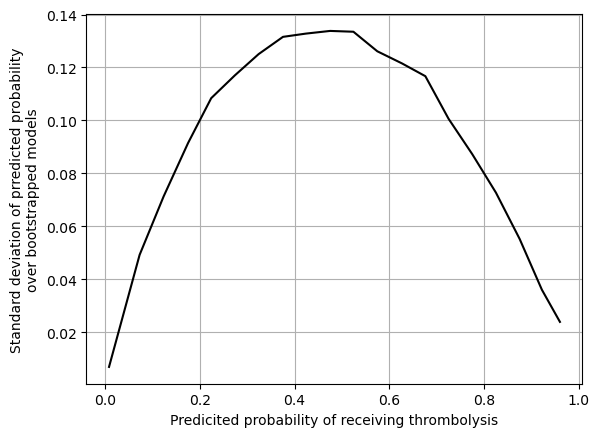

In [11]:
# Set up data frame of results
patient_predictions = pd.DataFrame()
patient_predictions['mean_prob'] = prediction_mean
patient_predictions['std_prob'] = prediction_std
# Bin mean probability of receiving thrombolysis
patient_predictions['bin'] = np.digitize(prediction_mean, bins = np.arange(0, 1.1, 0.05))
# Calculat emean results by bin
pivot = patient_predictions.groupby('bin').mean()

# Plot
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(pivot['mean_prob'], pivot['std_prob'], c='k')
ax.grid()
ax.set_xlabel('Predicited probability of receiving thrombolysis')
ax.set_ylabel('Standard deviation of prredicted probability\nover bootstrapped models')
plt.savefig(f'./output/50_bootstrap_prediction_sd.jpg', dpi=300)
plt.show()


### Pass 10k cohort through all hospital models and get thrombolysis rate

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining.

In [12]:
# Set up lists for split results
split_thrombolysis_10k_rates = []
split_individual_results = []

# Get list of hopsitals
hospitals = list(set(train['Stroke team']))
hospitals.sort()

for i in range(splits):

    thrombolysis_rate = []
    single_predictions = []

    for hospital in hospitals:

        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

        # Copy hospital dataframe and change hospital ID (after setting all to zero)
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
                
        # Get predicted probabilities and class
        y_probs = models[i].predict_proba(X_test_adjusted)[:,1]
        y_pred = y_probs > 0.5
        thrombolysis_rate.append(y_pred.mean())
        
        # Save predictions
        single_predictions.append(y_pred * 1)
    
    # Convert individual predictions (a list of arrays) to a NumPy array, and transpose
    patient_results = np.array(single_predictions).T
    # Convert to DataFrame
    patient_results = pd.DataFrame(patient_results)
    split_individual_results.append(patient_results)

    # Get thrombolysis rate
    thrombolysis_by_hosp = pd.DataFrame(index=hospitals)
    thrombolysis_by_hosp['Thrombolysis rate'] = thrombolysis_rate
    split_thrombolysis_10k_rates.append(thrombolysis_by_hosp)

Sort by hospital 10k thrombolysis rate.

In [13]:
# Concatenate results into a dataframe
split_thrombolysis_10k_rates = pd.concat(split_thrombolysis_10k_rates,axis=1)
split_thrombolysis_10k_rates.head()

,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,...,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate
AGNOF1041H,0.3036,0.2957,0.3412,0.2900,0.2831,0.3231,0.2756,0.3103,0.2986,0.3276,...,0.2812,0.2813,0.2922,0.3132,0.3322,0.2906,0.2835,0.2789,0.2928,0.3384
AKCGO9726K,0.3498,0.3477,0.3098,0.3220,0.3457,0.3516,0.3439,0.3425,0.3355,0.3335,...,0.3394,0.3373,0.3335,0.3334,0.3294,0.3373,0.3256,0.3442,0.3263,0.3281
AOBTM3098N,0.2118,0.2453,0.2299,0.2398,0.2648,0.2227,0.2306,0.2537,0.2445,0.2369,...,0.2374,0.2125,0.2577,0.2542,0.2488,0.2281,0.2242,0.2428,0.2057,0.2573
APXEE8191H,0.3134,0.2598,0.2806,0.2845,0.2684,0.2929,0.2676,0.2723,0.2873,0.2869,...,0.3138,0.2734,0.2688,0.2610,0.3030,0.3057,0.2961,0.3168,0.2598,0.2634
ATDID5461S,0.3385,0.3204,0.2810,0.2876,0.2818,0.3545,0.2930,0.2738,0.2911,0.3191,...,0.2875,0.3199,0.3113,0.3432,0.3047,0.2710,0.3200,0.3525,0.3298,0.2978


In [14]:
summary = split_thrombolysis_10k_rates.T.describe()
summary = summary.T
summary['single fit'] = single_fit_thrombolysis_10k_rate

# Add confidence limits
alpha = 0.95
length = len(split_thrombolysis_10k_rates)
loc = split_thrombolysis_10k_rates.mean(axis=1)
scale = split_thrombolysis_10k_rates.std(axis=1)
confidence = stats.t.interval(alpha, length, loc, scale)
summary['lower 95'] = loc - confidence[0]
summary['upper 95'] = confidence[1] - loc
summary['std'] = scale

# Identify order in ascending 10k thrombolysis rate
order = list(summary.sort_values('single fit').index)

Calculate mean standard deviation of bootstrap replicates for 10k thrombolysis rates.

In [15]:
mean_std = summary['std'].mean()
print(f'Mean standard deviation of bootstrap replicates {mean_std:0.3f}')

Mean standard deviation of bootstrap replicates 0.017


Plot boxplot

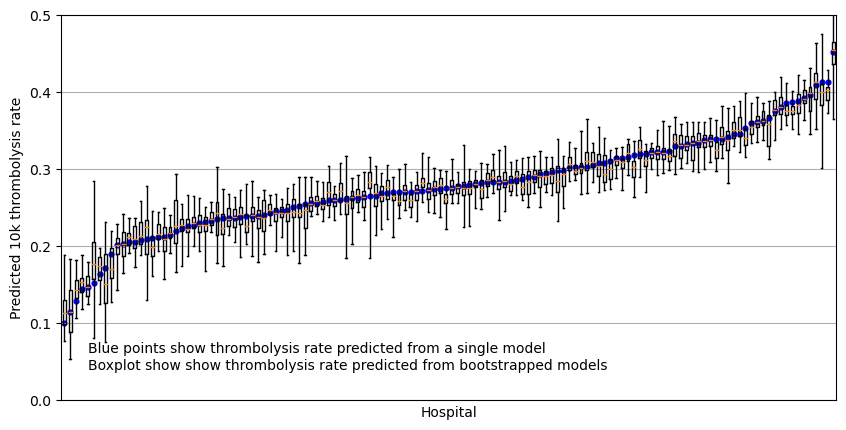

In [16]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
single_fit_values = summary.loc[order]['single fit']
x = np.arange(len(single_fit_values)) + 1
ax.scatter(x, single_fit_values, c='b', s=12)
ax.boxplot(split_thrombolysis_10k_rates.loc[order].T, whis=999)
ax.set_xlabel('Hospital')
ax.set_ylabel('Predicted 10k thrombolysis rate')
ax.set_ylim(0, 0.5)
ax.set_xticks([])
text = 'Blue points show thrombolysis rate predicted from a single model\nBoxplot show show thrombolysis rate predicted from bootstrapped models'
ax.text(5, 0.04, text)
ax.grid()
plt.show()

Plot mean and stanbdard deviation

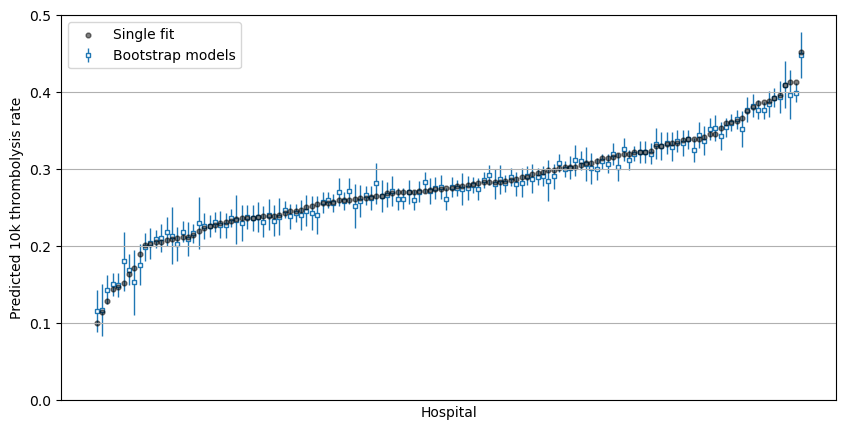

In [17]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
single_fit_values = summary.loc[order]['single fit']
x = np.arange(len(single_fit_values)) + 1


ax.errorbar(x, 
    summary.loc[order]['mean'], 
    yerr=(summary.loc[order]['std']),
    lw=1, ls='', marker='s', markersize=2.5, mfc='w',
    label='Bootstrap models',
    zorder=0)

ax.scatter(x, single_fit_values, c='k', s=12, alpha=0.5, label='Single fit', zorder=1)

ax.set_xlabel('Hospital')
ax.set_ylabel('Predicted 10k thrombolysis rate')
ax.set_ylim(0, 0.5)
ax.set_xticks([])
ax.legend()
ax.grid()
plt.savefig(f'./output/50_bootstrap_10k_sd.jpg', dpi=300)
plt.show()

## Create bootstrap sampled training sets using Bayesian bootstrapping

See: https://towardsdatascience.com/the-bayesian-bootstrap-6ca4a1d45148

In [18]:
N = len(train)
models = []
all_predictions = []

for i in range(splits):
    # Get weights
    bayesian_weights = np.random.dirichlet(alpha=np.ones(N)*1, size=1)[0] * N

    # Get X and y
    X_train = train.drop('Thrombolysis', axis=1)
    X_test = test.drop('Thrombolysis', axis=1)
    y_train = train['Thrombolysis']
    y_test = test['Thrombolysis']

    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('Stroke team', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('Stroke team', axis=1, inplace=True)  

    # Define and fit model
    model = XGBClassifier(verbosity=0, seed=42+i, learning_rate=0.5)
    model.fit(X_train, y_train, sample_weight=bayesian_weights)
    models.append(model)

    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test)[:,1]
    all_predictions.append(y_probs)
    y_pred = y_probs > 0.5

    # Show accuracy
    accuracy = np.mean(y_pred == y_test)
    print (f'Accuracy set {i}: {accuracy:.3f}')

Accuracy set 0: 0.846
Accuracy set 1: 0.845
Accuracy set 2: 0.845
Accuracy set 3: 0.840
Accuracy set 4: 0.843
Accuracy set 5: 0.843
Accuracy set 6: 0.842
Accuracy set 7: 0.844
Accuracy set 8: 0.847
Accuracy set 9: 0.843
Accuracy set 10: 0.844
Accuracy set 11: 0.845
Accuracy set 12: 0.840
Accuracy set 13: 0.844
Accuracy set 14: 0.847
Accuracy set 15: 0.842
Accuracy set 16: 0.844
Accuracy set 17: 0.848
Accuracy set 18: 0.845
Accuracy set 19: 0.845
Accuracy set 20: 0.846
Accuracy set 21: 0.845
Accuracy set 22: 0.843
Accuracy set 23: 0.845
Accuracy set 24: 0.845
Accuracy set 25: 0.842
Accuracy set 26: 0.845
Accuracy set 27: 0.842
Accuracy set 28: 0.840
Accuracy set 29: 0.840


Calculate mean standard deviation of bootstrap replicates for indiviial patient predictions.

In [19]:
all_predictions = np.array(all_predictions)
prediction_std = all_predictions.std(axis=0)
mean_std = prediction_std.mean()
print(f'Mean standard deviation of bootstrap replicates {mean_std:0.3f}')

Mean standard deviation of bootstrap replicates 0.054


Show relationship between probability of receiving thrombolysis, and variation in predicted probability over bootstrapped models.

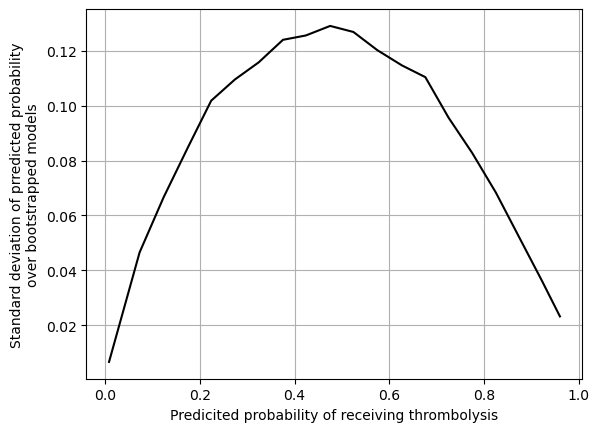

In [20]:
# Set up data frame of results
patient_predictions = pd.DataFrame()
patient_predictions['mean_prob'] = prediction_mean
patient_predictions['std_prob'] = prediction_std
# Bin mean probability of receiving thrombolysis
patient_predictions['bin'] = np.digitize(prediction_mean, bins = np.arange(0, 1.1, 0.05))
# Calculat emean results by bin
pivot = patient_predictions.groupby('bin').mean()

# Plot
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(pivot['mean_prob'], pivot['std_prob'], c='k')
ax.grid()
ax.set_xlabel('Predicited probability of receiving thrombolysis')
ax.set_ylabel('Standard deviation of prredicted probability\nover bootstrapped models')
plt.savefig(f'./output/50_bayesian_bootstrap_prediction_sd.jpg', dpi=300)
plt.show()


### Pass 10k cohort through all hospital models and get thrombolysis rate

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining.

In [21]:
# Set up lists for split results
split_thrombolysis_10k_rates = []
split_individual_results = []

# Get list of hopsitals
hospitals = list(set(train['Stroke team']))
hospitals.sort()

for i in range(splits):

    thrombolysis_rate = []
    single_predictions = []

    for hospital in hospitals:

        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

        # Copy hospital dataframe and change hospital ID (after setting all to zero)
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
                
        # Get predicted probabilities and class
        y_probs = models[i].predict_proba(X_test_adjusted)[:,1]
        y_pred = y_probs > 0.5
        thrombolysis_rate.append(y_pred.mean())
        
        # Save predictions
        single_predictions.append(y_pred * 1)
    
    # Convert individual predictions (a list of arrays) to a NumPy array, and transpose
    patient_results = np.array(single_predictions).T
    # Convert to DataFrame
    patient_results = pd.DataFrame(patient_results)
    split_individual_results.append(patient_results)

    # Get thrombolysis rate
    thrombolysis_by_hosp = pd.DataFrame(index=hospitals)
    thrombolysis_by_hosp['Thrombolysis rate'] = thrombolysis_rate
    split_thrombolysis_10k_rates.append(thrombolysis_by_hosp)

Sort by hospital 10k thrombolysis rate.

In [22]:
# Concatenate results into a dataframe
split_thrombolysis_10k_rates = pd.concat(split_thrombolysis_10k_rates,axis=1)
split_thrombolysis_10k_rates.head()

,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,...,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate
AGNOF1041H,0.2982,0.2952,0.2805,0.2814,0.2899,0.2841,0.2732,0.2883,0.2944,0.2848,...,0.3146,0.2872,0.3263,0.2767,0.2944,0.2863,0.2915,0.3071,0.2948,0.3054
AKCGO9726K,0.3236,0.3279,0.3325,0.3437,0.3303,0.3503,0.3098,0.3395,0.3322,0.3340,...,0.3454,0.3271,0.3145,0.3177,0.3239,0.3378,0.3538,0.3310,0.3482,0.3462
AOBTM3098N,0.2413,0.2290,0.2536,0.2656,0.2451,0.2417,0.2496,0.2486,0.2493,0.2368,...,0.2570,0.2670,0.2421,0.2456,0.2398,0.2410,0.2209,0.2412,0.2196,0.2442
APXEE8191H,0.2869,0.2812,0.2802,0.2626,0.2838,0.2693,0.2851,0.2856,0.2497,0.2883,...,0.3035,0.2604,0.2969,0.2715,0.2987,0.2788,0.2775,0.2822,0.2568,0.2866
ATDID5461S,0.3067,0.3267,0.3161,0.2824,0.3103,0.2943,0.3534,0.3266,0.2929,0.3270,...,0.3072,0.3611,0.3041,0.3020,0.3201,0.2892,0.2917,0.3507,0.3336,0.3255


In [23]:
summary = split_thrombolysis_10k_rates.T.describe()
summary = summary.T
summary['single fit'] = single_fit_thrombolysis_10k_rate

# Add confidence limits
alpha = 0.95
length = len(split_thrombolysis_10k_rates)
loc = split_thrombolysis_10k_rates.mean(axis=1)
scale = split_thrombolysis_10k_rates.std(axis=1)
confidence = stats.t.interval(alpha, length, loc, scale)
summary['lower 95'] = loc - confidence[0]
summary['upper 95'] = confidence[1] - loc
summary['std'] = scale

# Identify order in ascending 10k thrombolysis rate
order = list(summary.sort_values('single fit').index)

Calculate mean standard deviation of bootstrap replicates for 10k thrombolysis rates.

In [24]:
mean_std = summary['std'].mean()
print(f'Mean standard deviation of bootstrap replicates {mean_std:0.3f}')

Mean standard deviation of bootstrap replicates 0.016


Plot boxplot

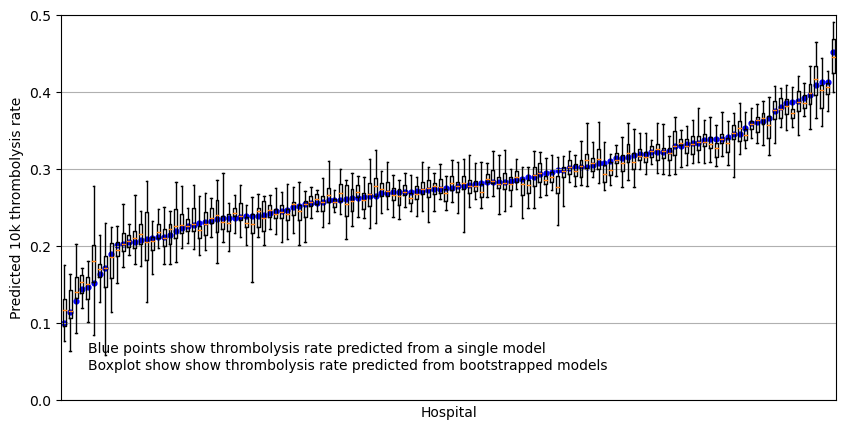

In [25]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
single_fit_values = summary.loc[order]['single fit']
x = np.arange(len(single_fit_values)) + 1
ax.scatter(x, single_fit_values, c='b', s=12)
ax.boxplot(split_thrombolysis_10k_rates.loc[order].T, whis=999)
ax.set_xlabel('Hospital')
ax.set_ylabel('Predicted 10k thrombolysis rate')
ax.set_ylim(0, 0.5)
ax.set_xticks([])
text = 'Blue points show thrombolysis rate predicted from a single model\nBoxplot show show thrombolysis rate predicted from bootstrapped models'
ax.text(5, 0.04, text)
ax.grid()
plt.show()

Plot mean and stanbdard deviation

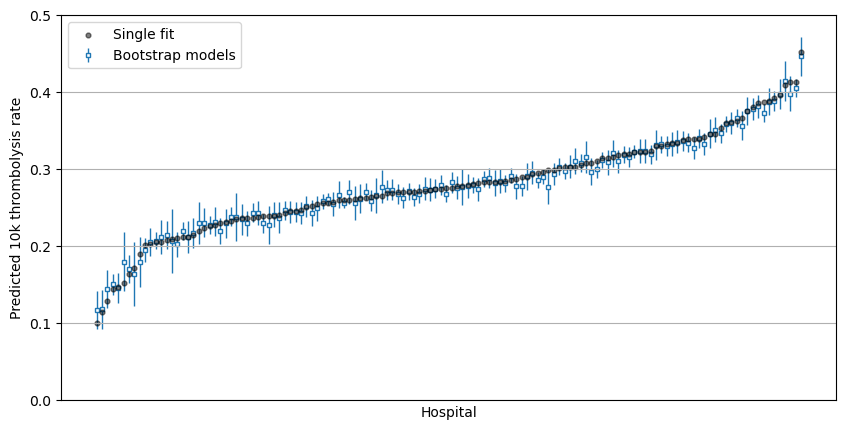

In [26]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
single_fit_values = summary.loc[order]['single fit']
x = np.arange(len(single_fit_values)) + 1


ax.errorbar(x, 
    summary.loc[order]['mean'], 
    yerr=(summary.loc[order]['std']),
    lw=1, ls='', marker='s', markersize=2.5, mfc='w',
    label='Bootstrap models',
    zorder=0)

ax.scatter(x, single_fit_values, c='k', s=12, alpha=0.5, label='Single fit', zorder=1)

ax.set_xlabel('Hospital')
ax.set_ylabel('Predicted 10k thrombolysis rate')
ax.set_ylim(0, 0.5)
ax.set_xticks([])
ax.legend()
ax.grid()
plt.savefig(f'./output/50_bayesian_bootstrap_10k_sd.jpg', dpi=300)
plt.show()